In [6]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from API

In [7]:
import os
from dotenv import load_dotenv

In [8]:
load_dotenv('./../controller/.env')


True

In [9]:
print(os.getenv("API_URL"))

https://zerofourtwo.new/api


In [10]:
# load dataset from api
headers = {"Authorization": f"Bearer {os.getenv('API_SECRET_KEY')}"}
df = pd.read_json(r'https://zerofourtwo.net/api/dataset', storage_options=headers)

In [11]:

#df = df.query("_user == 'intotito'")
df.shape

(407, 14)

In [12]:
hMzx = df.iloc[:, [2, 9]]

df.groupby('_user')['bm_HR_max'].max()
df.loc[df['bm_HR_max'] == 0, 'bm_HR_max'] = df['bm_HR_max'].mean()

In [13]:
dfK = df.query("bm_HR_max > 0")
dfK

,_id,_date,_user,fm_avg_trk_time,fm_accuracy,vx_avg_res_time,vx_shot_accuracy,vx_trg_accuracy,au_avg_res_time,bm_HR_max,bm_HR_avg,bm_HR_var,bm_act_steps,bm_sleep
0,1,2024-02-22T12:29:53.000Z,jjj,5.12871,70.5882,2.61127,35.48390,45.8333,2655.41,189.0,NaN,NaN,NaN,NaN
1,2,2024-02-22T23:25:08.000Z,jjj,2.25510,92.3077,2.49034,50.81970,67.3913,1670.35,189.0,NaN,NaN,NaN,NaN
12,13,2024-03-12T13:10:54.000Z,jjj,8.45288,52.1739,3.12482,43.58970,80.9524,3495.20,220.0,NaN,NaN,NaN,NaN
82,83,2024-01-29T12:32:21.000Z,intotito,NaN,NaN,4.03231,6.66667,10.0000,NaN,183.0,NaN,NaN,NaN,NaN
83,84,2024-01-29T12:33:53.000Z,intotito,NaN,NaN,1.24966,NaN,NaN,NaN,183.0,NaN,NaN,NaN,NaN
103,104,2024-03-12T11:08:18.000Z,intotito,2.44933,75.0000,2.53853,49.18030,76.9231,2361.26,220.0,NaN,NaN,NaN,NaN
231,232,2021-06-28T08:59:23.000Z,smythc2,4.54340,63.1579,2.75481,39.47370,55.5556,3203.34,201.0,61.0,46.0,9275.0,5.0
242,243,2021-08-30T09:37:07.000Z,smythc2,3.80792,85.7143,2.57946,44.64290,89.2857,2744.58,202.0,55.0,71.0,758.0,6.0
292,293,2023-08-14T13:32:29.000Z,smythc2,5.24395,80.0000,2.16583,46.29630,96.1538,2439.58,204.0,NaN,NaN,NaN,NaN
304,305,2024-03-12T11:03:00.000Z,rodrigo,2.58687,80.0000,2.06647,52.94120,81.8182,2192.95,220.0,NaN,NaN,NaN,NaN


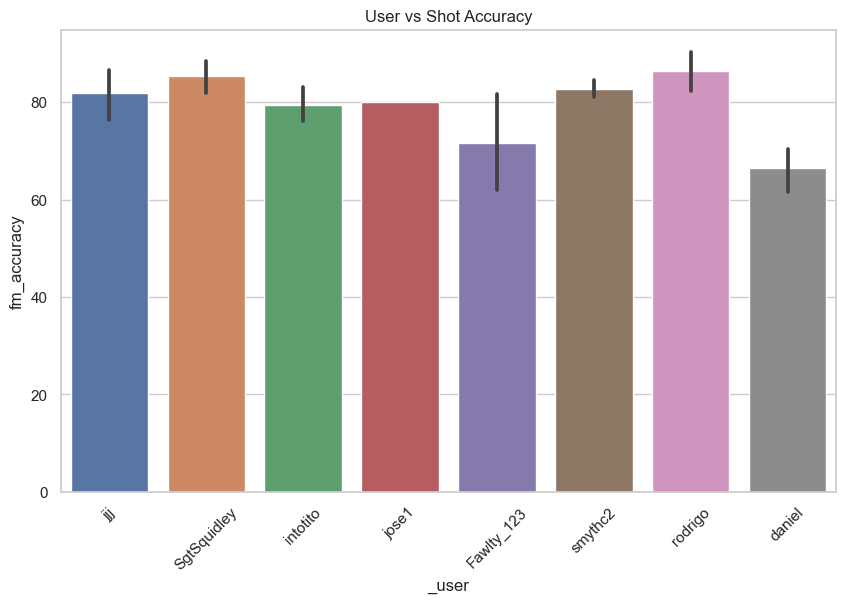

In [14]:
# plot _user vs vx_shot_accuracy
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x="_user", y="fm_accuracy", data=df)
plt.title("User vs Shot Accuracy")
plt.xticks(rotation=45)
plt.show()


# Clean Dataset

In [15]:
# delete unwanted columns
unwanted_columns = ['_id', '_date', '_user', 'bm_HR_max', 'bm_act_steps']
df_wanted = df.drop(unwanted_columns, axis=1)

In [16]:
# drop rows with missing values
df_wanted = df_wanted.dropna()
df_wanted.isna().sum()

fm_avg_trk_time     0
fm_accuracy         0
vx_avg_res_time     0
vx_shot_accuracy    0
vx_trg_accuracy     0
au_avg_res_time     0
bm_HR_avg           0
bm_HR_var           0
bm_sleep            0
dtype: int64

In [17]:
df_wanted.shape

(83, 9)

# Inspect data

In [18]:
df_wanted.head()

,fm_avg_trk_time,fm_accuracy,vx_avg_res_time,vx_shot_accuracy,vx_trg_accuracy,au_avg_res_time,bm_HR_avg,bm_HR_var,bm_sleep
3,2.67675,85.7143,2.63325,48.4375,75.6098,2147.90,58.0,68.0,3.0
4,2.95700,80.0000,2.01916,58.0645,83.7209,1875.10,59.0,60.0,3.0
6,2.05001,100.0000,2.04148,47.6190,68.1818,2211.87,61.0,77.0,3.0
8,9.32091,40.0000,2.74594,47.2222,62.9630,3254.95,59.0,71.0,4.0
10,2.24675,92.3077,1.94884,57.3770,70.0000,2017.87,60.0,61.0,4.0


In [19]:
df_wanted.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fm_avg_trk_time,83.0,2.845990,1.286166,1.25387,1.94483,2.35385,3.690705,9.32091
fm_accuracy,83.0,83.146048,11.663562,40.00000,75.00000,85.71430,92.307700,100.00000
vx_avg_res_time,83.0,2.087514,0.465463,1.35264,1.75189,2.00384,2.460495,3.10358
vx_shot_accuracy,83.0,53.083167,8.025283,39.13040,46.72520,53.22580,59.346900,73.91300
vx_trg_accuracy,83.0,84.609257,9.875494,55.55560,78.34820,86.95650,92.153850,97.91670
au_avg_res_time,83.0,2143.700482,687.873331,0.00000,1825.77500,2100.27000,2583.290000,3970.41000
bm_HR_avg,83.0,65.277108,7.123156,53.00000,60.00000,65.00000,70.000000,88.00000
bm_HR_var,83.0,47.686747,15.522547,18.00000,37.00000,43.00000,53.000000,83.00000
bm_sleep,83.0,3.819277,1.190865,1.00000,3.00000,4.00000,5.000000,6.00000


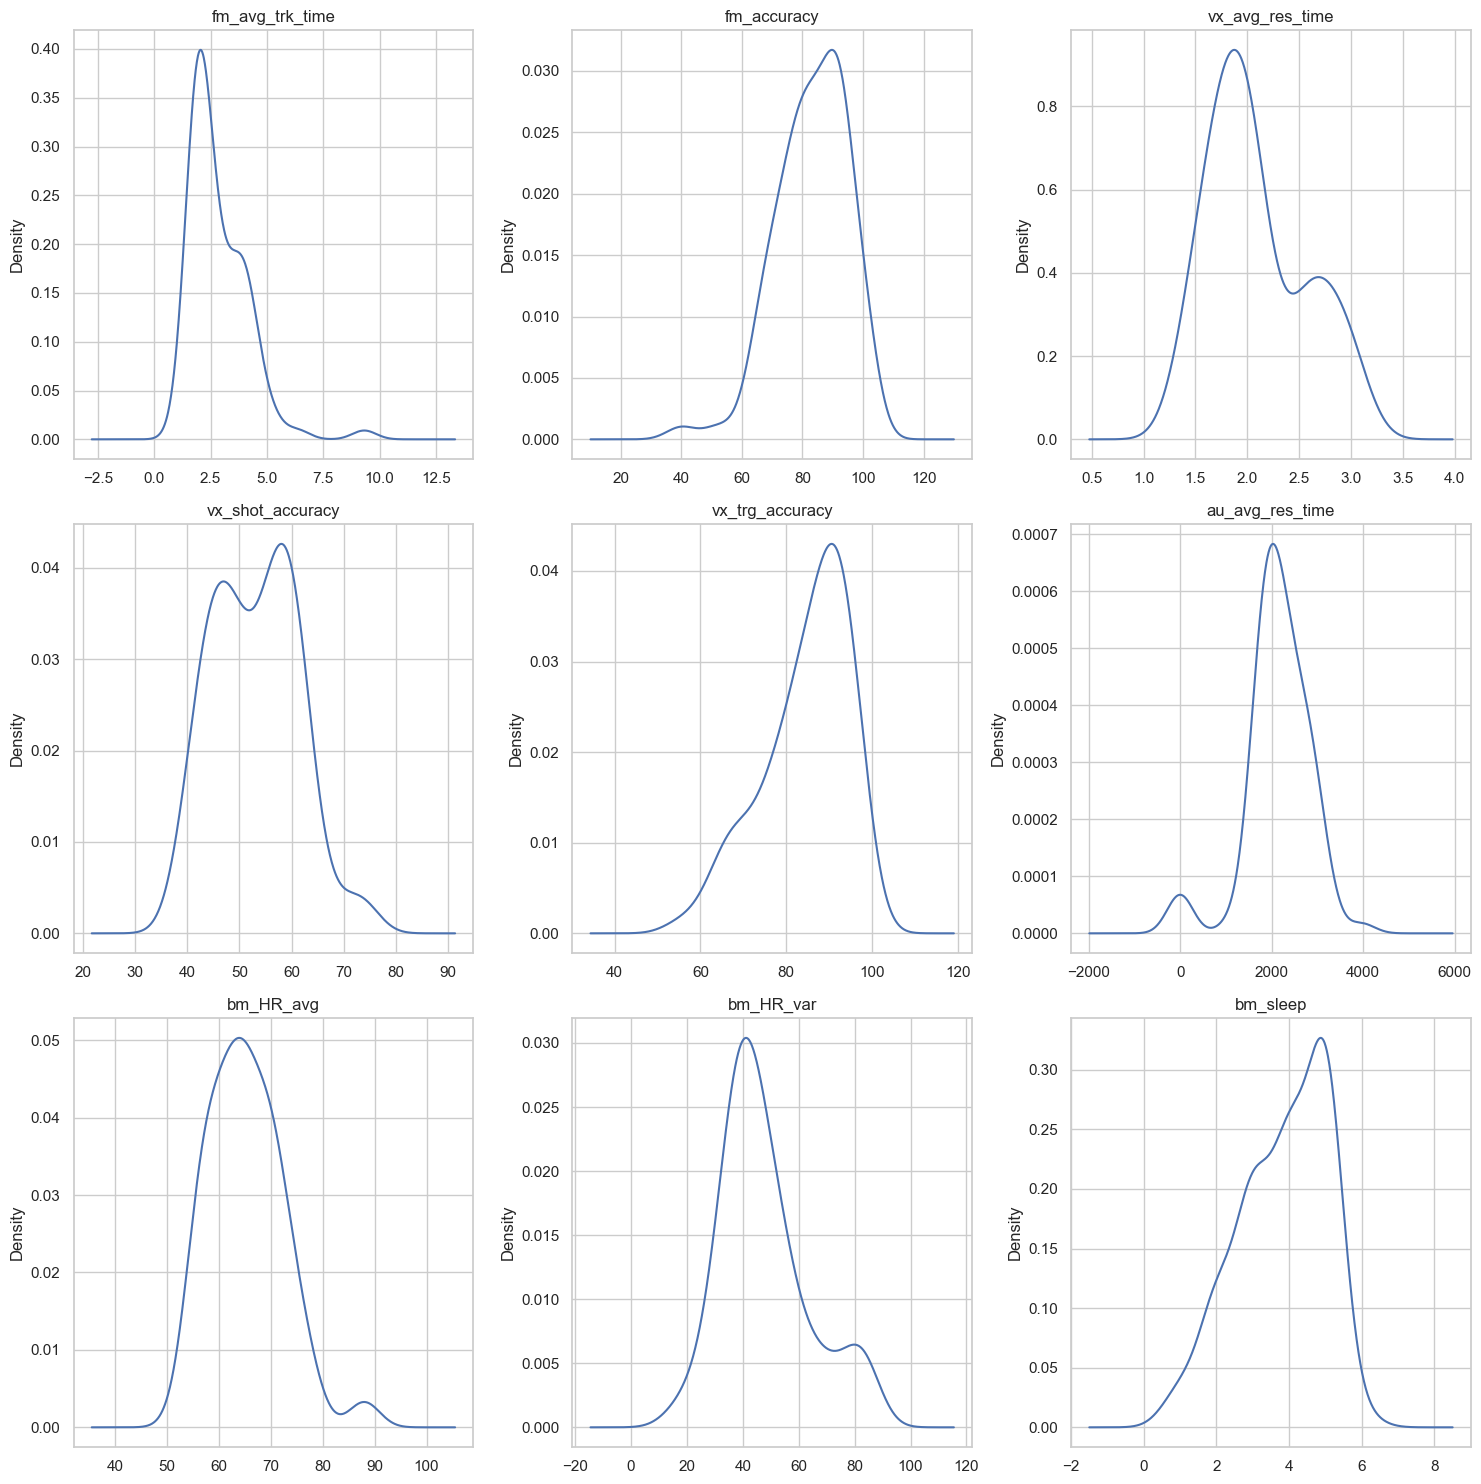

In [20]:
# plot normal distribution curve for each column using subplots
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i, column in enumerate(df_wanted.columns):
    ax = plt.subplot(3, 3, i+1)
    df_wanted[column].plot(kind='kde', ax=ax)
    ax.set_title(column)
plt.tight_layout()
plt.show()



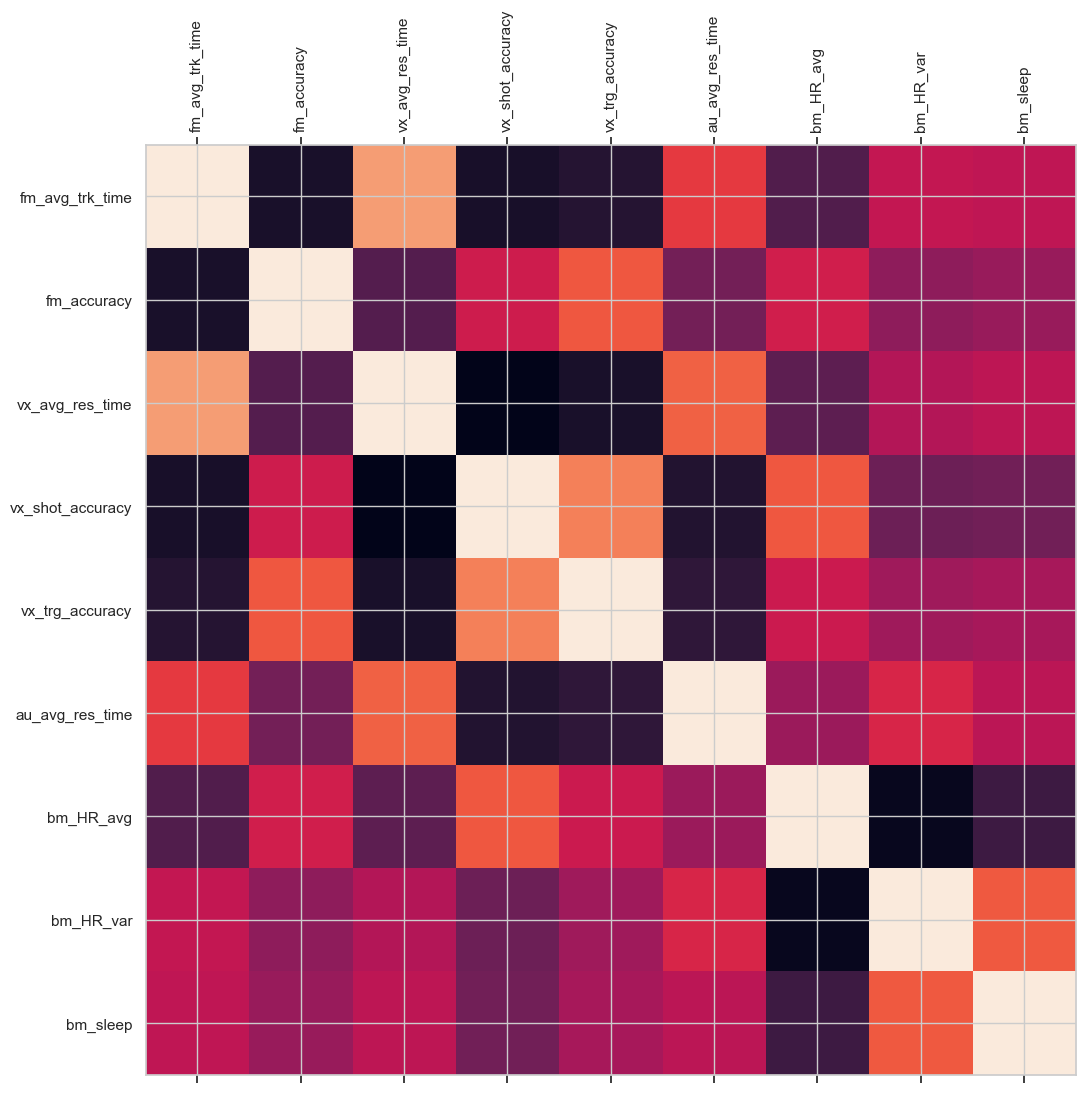

In [21]:
# show correlation matrix
correlation_matrix = df_wanted.corr()
plt.figure(figsize=(12, 12))
plt.matshow(correlation_matrix, fignum=1)
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation='vertical')
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
#plt.colorbar()
plt.show()



In [22]:
df_independent = df_wanted.iloc[:, -3:]
df_independent.shape

(83, 3)

In [23]:
df_dependent = df_wanted.iloc[:, :-3]
df_dependent.shape

(83, 6)

# Regression Model to predict vx_shot_accuracy using independent variables as input

In [24]:
# split dataset into training and testing
#from keras.models import LinearRegression
from sklearn.model_selection import train_test_split

X = df_independent
y = df_dependent

In [25]:
# scale the data
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4217)

In [27]:
X_train

array([[ 0.66706423, -0.75746538, -0.69215005],
       [-1.73402667,  1.2517701 ,  0.15268016],
       [-0.03913897, -0.75746538,  0.15268016],
       [ 0.94954552, -1.21116371, -1.53698026],
       [ 0.52582359, -0.69265133, -0.69215005],
       [-0.03913897, -0.36858109,  0.15268016],
       [ 1.2320268 ,  0.73325772,  0.99751037],
       [-0.03913897, -0.75746538,  0.15268016],
       [ 1.2320268 ,  0.27955939,  0.15268016],
       [-0.18037961, -0.62783728, -0.69215005],
       [-1.1690641 ,  0.14993129, -0.69215005],
       [ 1.2320268 ,  0.27955939,  0.15268016],
       [ 0.38458295, -0.36858109,  0.15268016],
       [ 0.10210167, -1.08153562, -0.69215005],
       [ 1.65574872, -0.43339514, -1.53698026],
       [-0.32162026,  0.0203032 ,  0.99751037],
       [-0.03913897,  1.31658415, -2.38181047],
       [-0.18037961, -0.69265133,  0.15268016],
       [ 0.52582359, -0.30376704,  0.99751037],
       [-0.74534218,  0.47400153,  0.99751037],
       [ 0.66706423, -0.95190752, -0.692

In [28]:
# create linear regression model with 3 input and 6 output
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(3, input_dim=3, activation='tanh'))
model.add(tf.keras.layers.Dense(10, activation='tanh'))
model.add(tf.keras.layers.Dense(15, activation='tanh'))
model.add(tf.keras.layers.Dense(6, activation='tanh'))



In [29]:
# compile model
model.compile(optimizer='adam', loss='mean_squared_error')


In [53]:
# train model
ak = model.fit(X_train, y_train, epochs=1000, batch_size=10, verbose=0)



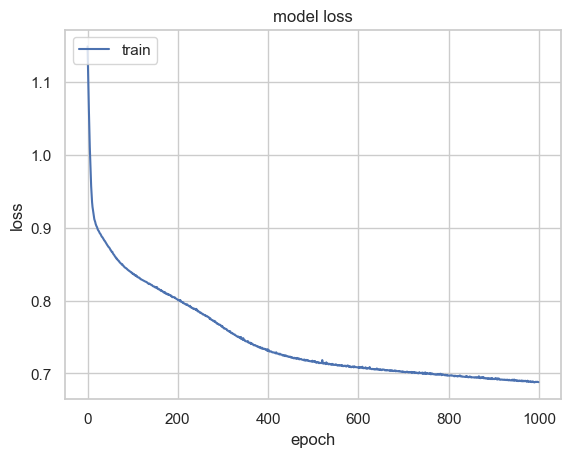

In [31]:
# plot training and validation loss
plt.plot(model.history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [54]:
# calculate r2 score
from sklearn.metrics import r2_score
y_pred = model.predict(X_test)
r2Score = r2_score(y_test, y_pred)




1/1 [==============================] - 0s 30ms/step


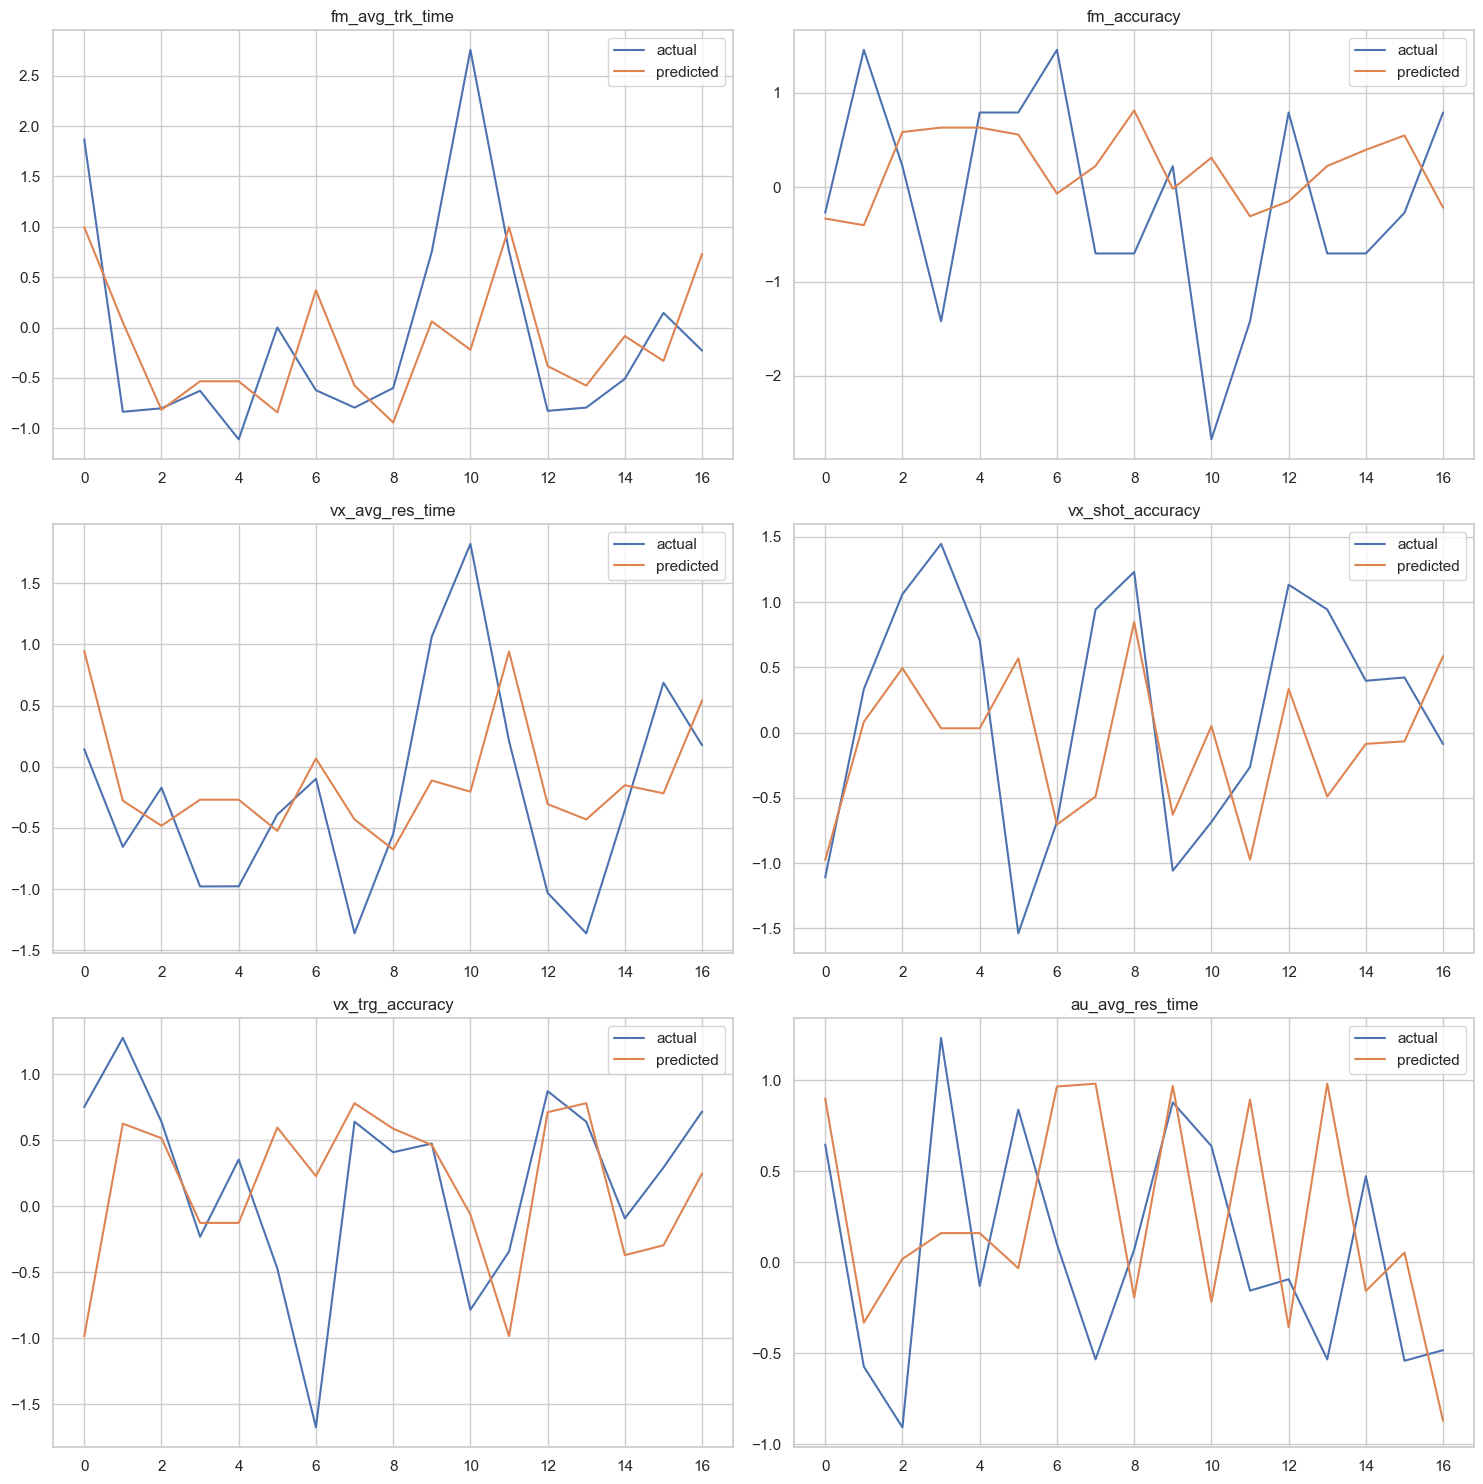

In [33]:
# plot actual vs predicted for each column
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
for i, column in enumerate(df_dependent.columns):
    ax = plt.subplot(3, 2, i+1)
    ax.plot(y_test[:, i], label='actual')
    ax.plot(y_pred[:, i], label='predicted')
    ax.set_title(column)
    ax.legend()
plt.tight_layout()
plt.show()

In [44]:
# evaluate r2 score for the model
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)


-0.43268089687635775

In [45]:
# evaluate r2 score for training data
y_pred_train = model.predict(X_train)
r2_score(y_train, y_pred_train)


3/3 [==============================] - 0s 2ms/step


0.4820815303862498

3/3 [==============================] - 0s 4ms/step


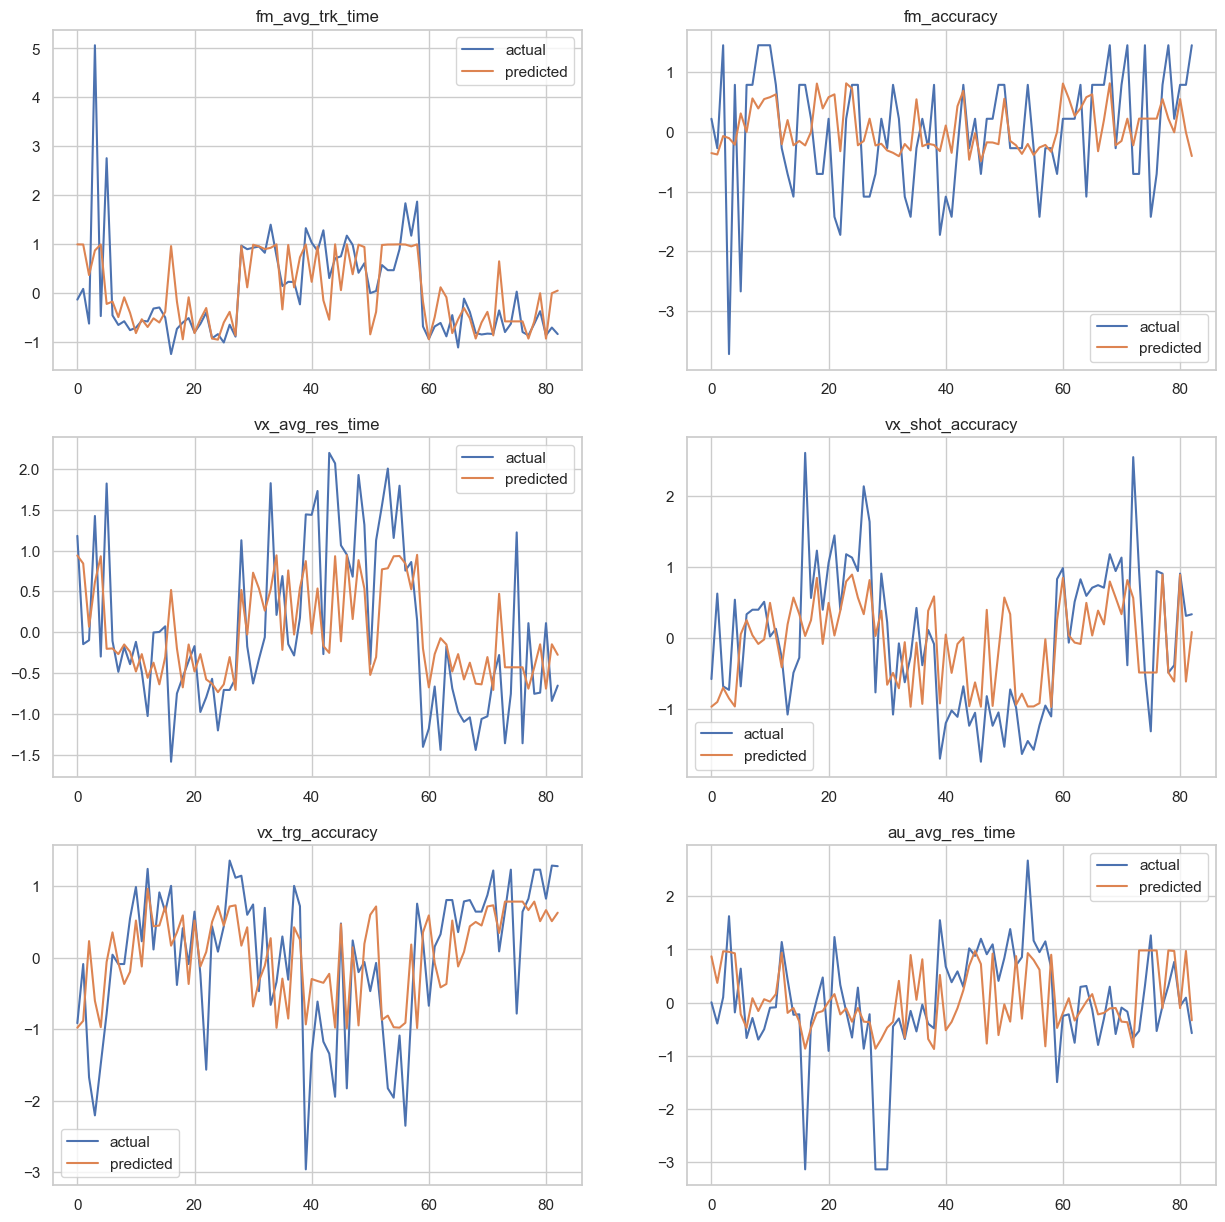

In [36]:
# evaluate prediction for all data
y_pred_all = model.predict(X)
r2_score(y, y_pred_all)

# plot actual vs predicted for each column
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
for i, column in enumerate(df_dependent.columns):
    ax = plt.subplot(3, 2, i+1)
    ax.plot(y[:, i], label='actual')
    ax.plot(y_pred_all[:, i], label='predicted')
    ax.set_title(column)
    ax.legend()
plt.show()





In [37]:
# calculate r2 score for each output displaying label of columns
r2_scores = []
for i, column in enumerate(df_dependent.columns):
    r2 = r2_score(y[:, i], y_pred_all[:, i])
    r2_scores.append((column, r2))
r2_scores



[('fm_avg_trk_time', 0.3505143359152758),
 ('fm_accuracy', 0.017737527552375898),
 ('vx_avg_res_time', 0.3292057508453532),
 ('vx_shot_accuracy', 0.3133666026633227),
 ('vx_trg_accuracy', 0.41010007158931117),
 ('au_avg_res_time', 0.2213026938339957)]